# Bridging Neural Dynamics: extending TRFs - Part 1

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Hugo-W/CNSP25_tutorial_HWeissbart/main/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hugo-W/CNSP25_tutorial_HWeissbart/blob/main/notebooks/part_1.ipynb)

Firstly, let's review our intuitive understanding behind Temporal Response Functions (TRF), we will start by simulating signals, building our ground truth TRFs and convolve them with our own designed feature signals. This will allow us to observe in particular why one may say that we do not need regularisation for impulse-like features for instance.

### Setup (Google Colab only)

> We need an extra step to make sure widgets can work in Collab notebooks, uncomment and run the cell bellow if using Google Collab, otherwise just skip this.

In [2]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %pip install -q ipywidgets ipympl
    %pip install -q natmeeg

In [ ]:
import sys
if IN_COLAB and 'natmeeg' not in sys.modules:
    print("🔁 Restarting kernel to use newly installed packages...")
    get_ipython().kernel.do_shutdown(True) # type: ignore

In [ ]:
# Download `utils`
if IN_COLAB:
    import requests
    import os

    files = ['__init__.py', 'helpers.py', 'surrogate.py', 'visu.py', 'utils.py']
    # Create utils directory if it doesn't exist
    os.makedirs('utils', exist_ok=True)
    for f in files:
        url = f'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/utils/{f}'
        response = requests.get(url)

        with open(f'utils/{f}', 'wb') as f:
            f.write(response.content)

    from google.colab import output # type: ignore
    output.enable_custom_widget_manager()

## Imports

First let's get all the libraries, data and path setup.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, HTML, HTMLMath, Checkbox, FloatSlider, IntSlider, Dropdown, interact, Button, Dropdown
import tqdm.notebook as tqdm
import sys, os
# Add utils to Python path
sys.path.append('..') # access to utils.py and visu.py modules
from utils.utils import download_file, list_h5_data
from utils.visu import plot_fft
from utils.surrogate import (simulate_background_eeg, simulate_band_power, simulate_regular_events,
                             simulate_smooth_signal, create_kernel)
from utils.helpers import lowpass_filter, convolve_with_kernel, lag_matrix, lag_span, _svd_regress, conjugate_gradient_solver
from utils.helpers import convolve_with_kernel, lag_matrix, lag_span, _svd_regress

from scipy.signal import filtfilt, butter, welch

# For darkbackground:
plt.style.use('dark.mplstyle')

%matplotlib widget

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

## Simulating input and response signals

We will first simulate different input signals:
- A series of impulses (akin to word or phoneme onsets)
- A series of **valued** impulses (akin to word surprisal)
- A smooth continuous signal (akin to a sound envelope)

In [4]:
# Parameters
rng = np.random.default_rng(2025)  # for reproducibility
fs = 100  # Sampling rate in Hz
duration = 30  # Duration in seconds
tmin = -0.2  # Kernel start time in seconds
tmax = 0.6  # Kernel end time in seconds
n_samples = int(fs * duration)  # Total number of samples

N events: 194.0


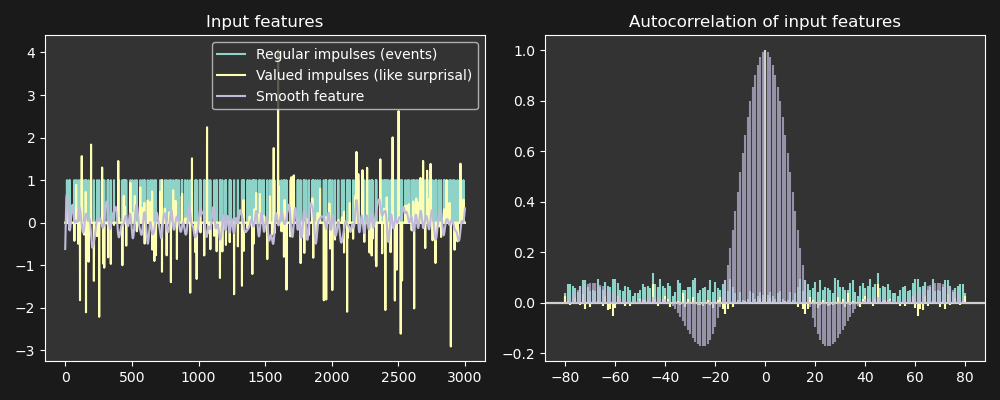

In [5]:
plt.close('Stimulus')
impulses = simulate_regular_events(interval=0.15, jitter=0.1)
valued_impulses = impulses * rng.normal(size=impulses.shape)
print(f"N events: {np.sum(impulses)}")

# Cutoff for smoothing
fc = 3.  # Hz
# Design the Butterworth lowpass filter
b, a = butter(4, fc, fs=100)
smoothed_signal = filtfilt(b, a, rng.normal(size=impulses.shape))
# smoothed_signal = filtfilt(b, a, valued_impulses)*8.

fig, ax = plt.subplots(1, 2, figsize=(10, 4), num='Stimulus')
ax[0].plot(impulses       , label='Regular impulses (events)')
ax[0].plot(valued_impulses, label='Valued impulses (like surprisal)')
ax[0].plot(smoothed_signal, label='Smooth feature')
ax[0].set_title('Input features')
ax[0].legend()

# Autocorrelation functions fo features:
ax[1].acorr(impulses       , maxlags=80, label='Regular impulses (events)', color='C0')
ax[1].acorr(valued_impulses, maxlags=80, label='Valued impulses (like surprisal)', color='C1')
ax[1].acorr(smoothed_signal, maxlags=80, label='Smooth feature', color='C2', alpha=0.7)
ax[1].set_title('Autocorrelation of input features')
plt.tight_layout()


Then, let's simulate three different kernels to play with, these will be our _ground truth_ Temporal Response Functions.

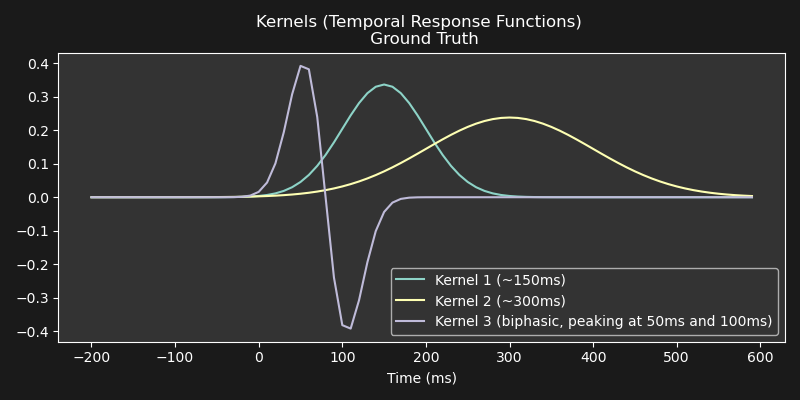

In [6]:
plt.close('Kernels')

# Create three different kernels
tker, ker1 = create_kernel(loc=0.15, spread=0.05) # A fast response
_, ker2 = create_kernel(loc=0.3, spread=0.1) # a longish response
_, ker3 = create_kernel(loc=0.08, spread=0.025, bipolar=True) # an even faster response with N1/P2 morphology

plt.figure('Kernels', figsize=(8, 4))
plt.plot(tker*1e3, ker1, label='Kernel 1 (~150ms)')
plt.plot(tker*1e3, ker2, label='Kernel 2 (~300ms)')
plt.plot(tker*1e3, ker3, label='Kernel 3 (biphasic, peaking at 50ms and 100ms)')
plt.title('Kernels (Temporal Response Functions) \n Ground Truth')
plt.xlabel('Time (ms)')
plt.legend()
plt.tight_layout()


Finally, by convolving the input signals with the kernels one can generate our response signal. We can then add noise to it ro make it more M/EEG like adding background $1/f$ noise and adding power in the alpha band.

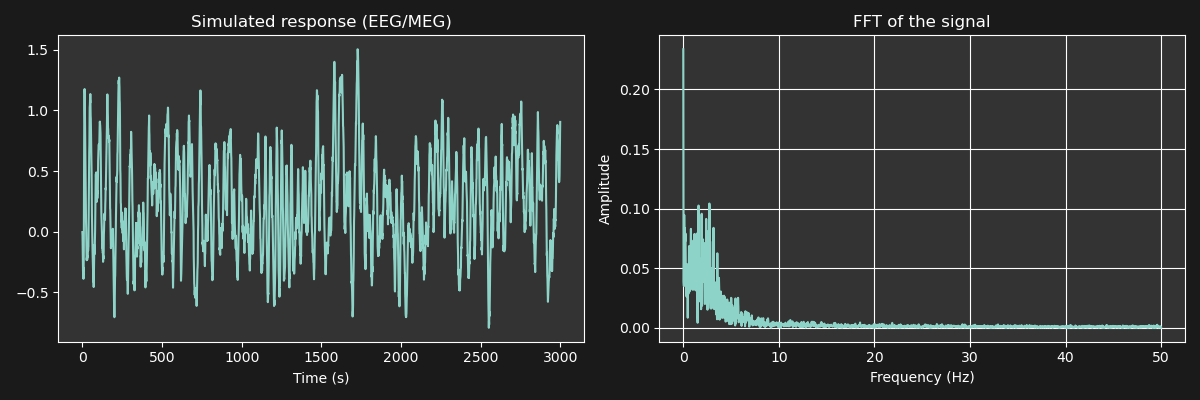

In [7]:
trf_params = {
    'tmin': tmin,
    'tmax': tmax,
    'fs': fs,
}
resp = convolve_with_kernel(impulses, ker1, **trf_params)
resp += convolve_with_kernel(valued_impulses, ker2, **trf_params)
resp += convolve_with_kernel(smoothed_signal, ker3, **trf_params)
# Add some noise and "alpha power":
alpha_contrib = 0.
one_over_f_contrib = .05
resp += simulate_background_eeg(alpha=0.9, fs=fs)*one_over_f_contrib + alpha_contrib*simulate_band_power(sampling_rate=fs, duration=duration,)

# Visualisation
plt.close('Response')
f, ax = plt.subplots(1, 2, figsize=(12, 4), num='Response')
ax[0].plot(resp)
ax[0].set_title('Simulated response (EEG/MEG)')
ax[0].set_xlabel('Time (s)')
plot_fft(resp, fs=fs, ax=ax[1])
plt.tight_layout()

We can very easily estimate the TRF using ordinary least squares or Ridge regression. Let's briefly recap the maths...

Firstly, we recall that one can rewrite the discrete (and finite time) convolution in a vectorized format by designing a matrix of features $\mathbf{X} \in \mathbb{R}^{N\times k}$ (with $N$ samples, and $k=d\times n_{lags}$, for $d$ features and $n_{lags}$ lags considered in the convolution). Thus, we are reformulating $\hat{\mathbf{y}}(t) = \sum_d \left\{ x_d(t) \star \beta \right\}(t) = \sum_d \sum_{\tau} x_d(t-\tau) \beta(\tau)$ as $\hat{\mathbf{Y}} = \mathbf{X}\beta$, a simple linear formulation of the model (in the form of $AX=B$).

We know that for $N \gt k$, meaning that $\mathbf{X}$ is not square and rather longer than wider, **no exact solution exists**, but one can find a **unique solution** to the optimisation problem which tries to minimise the least-squared error between estimated $\hat{\mathbf{Y}}$ and the true $\mathbf{Y}$. There is another way to arrive to the same unique _least-square_ solution, by passing through the _normal equation_ which looks at another linear equation but this time with "$\mathbf{A}$" being square:

\begin{align}
\mathbf{Y} &= \mathbf{X}\beta\\
\mathbf{X^T}\mathbf{Y} &= \mathbf{X^T}\mathbf{X}\beta\\
\nonumber\\ 
\beta_{OLS} &= \left(\mathbf{X^T}\mathbf{X}\right)^{-1}\mathbf{X^T}\mathbf{Y}\\
\end{align}

Equation (3) is solution to (2), and it also corresponds to the least-square solution (minimising the squared error). Now $\mathbf{X}^T\mathbf{X}$ is indeed a square matrix, thus invertible if all its eigenvalues are strictly non-zero (actually positive, as it's a symmetric matrix anyway). The fact is that **numerically** the eigenvalues will **never exactly be zero** so we will always be able to compute this solution. But this is not necessarily good, and it is exactly what we mean by **fitting the noise/overfitting/...**. A simple solution is to shift it seigenvalues away from zero by adding "weight" to the diagonal of $\mathbf{X}^T\mathbf{X}$ (i.e. creating a more pronounced "ridge" in the matrix):

$$
\beta_{ridge} = \left(\mathbf{X^T}\mathbf{X} + \lambda I_k\right)^{-1}\mathbf{X^T}\mathbf{Y}
$$

Here we described exactly the solution to the Ridge regression problem, with a new term $\lambda I_k$, the _regularising_ term, also known as a Tikhonov regularisation.

> The question is really: _what give rise to small/close-to-zero eigenvalues of $\mathbf{X}^T\mathbf{X}$?_

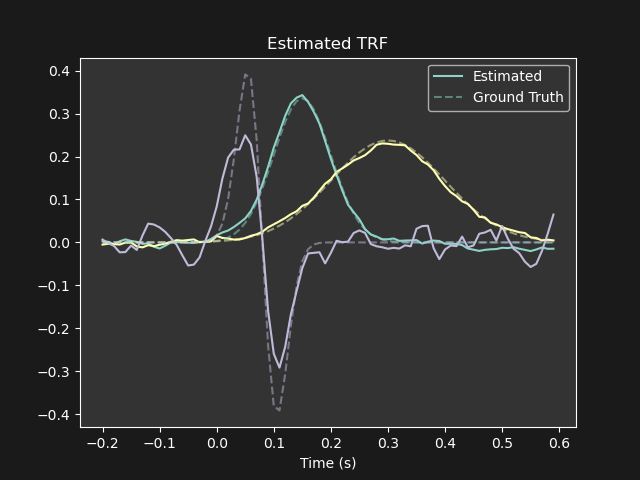

In [8]:
# First we create the multi-dimensional feature vector
x = np.c_[impulses, valued_impulses, smoothed_signal]
# Then we create the lagged version of it: X
lags = lag_span(-0.2, 0.6, srate=100) + 1 # shifted because of how lag_span uses `np.ceil`
X = lag_matrix(x, lags)

# Now we can estimate the TRF using simple linear regression
alpha = 1.0
proj = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T
beta = proj @ resp
beta = beta.reshape(len(lags), x.shape[1], order='F')
plt.close('TRF')
plt.figure('TRF')
lines = plt.plot(tker, beta)
gt_lines = plt.plot(tker, np.c_[ker1, ker2, ker3], linestyle='--', alpha=0.5)
for l, g in zip(lines, gt_lines):
    g.set_color(l.get_color()) # match colors
# Legend for - and --, but with dummy lines:
plt.legend([lines[0], gt_lines[0]], ['Estimated', 'Ground Truth'])
plt.title('Estimated TRF')
plt.xlabel('Time (s)');

Let's try different values for our regularisation $\alpha$ (in the code we use `alpha` simply to avoid the built-in python name `lambda`) and see how it affects the content of the estimated TRF in terms of frequency spectrum. We will observe that _somehow_, increasing the regularising parameter acts as a low-pass filter...

Also note the effect of regularisation on TRF for impulse-related features: they only scale them down.

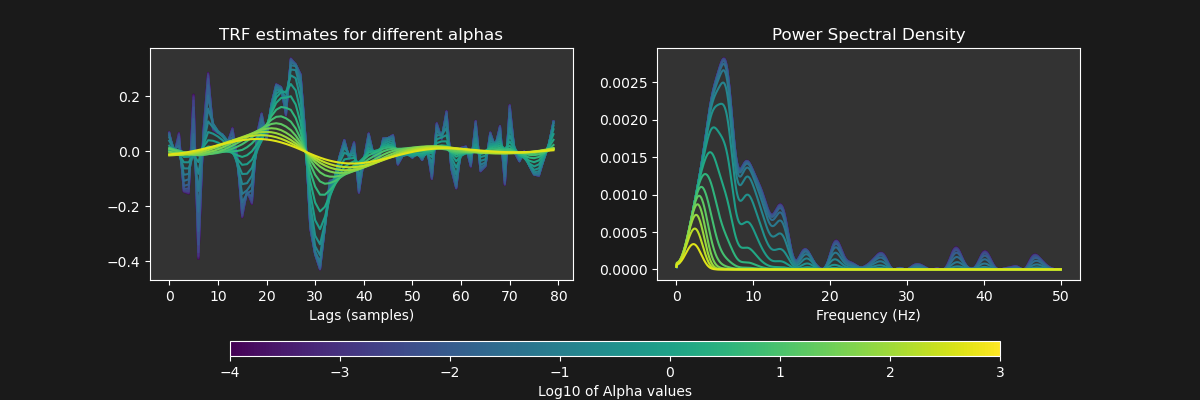

In [9]:
alphas = np.logspace(-4, 3, 20)
beta = _svd_regress(X, resp[:, None], alpha=alphas).squeeze()

# Visualisation
feature = 2 # which feature to plot
plt.close('TRF_alphas')
f, ax = plt.subplots(1, 2, figsize=(12, 4), num='TRF_alphas')
for k, b in enumerate(beta.T):
    color = plt.cm.viridis(k / len(alphas))
    ax[0].plot(b.reshape(len(lags), x.shape[1], order='F')[:, feature], color=color)
    freqs, psd = welch(b.reshape(len(lags), x.shape[1], order='F')[:, feature], fs=fs, nperseg=len(lags), nfft=2048)
    ax[1].plot(freqs, psd, color=color)
ax[0].set_title('TRF estimates for different alphas')
ax[1].set_title('Power Spectral Density')
ax[0].set_xlabel('Lags (samples)')
ax[1].set_xlabel('Frequency (Hz)')
log_alphas = np.log10(alphas)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=log_alphas.min(), vmax=log_alphas.max())), ax=ax,
                    orientation='horizontal', label='Log10 of Alpha values', aspect=50, fraction=0.05, pad=0.2)
f.subplots_adjust(bottom=0.3)


Let's now directly look into how $\mathbf{X}.T\mathbf{X}$ look for different feature type, and how the eigenvalue spectra change for each.

> Note that in algebra, the ratio of the largest eigenvalue over the smallest eigenvalue is called the **condition number** of the matrix. A high condition number indicates ill-conditioning, which means that the matrix is close to being singular (not invertible). In practical terms, ill-conditioning implies that small changes in the data can lead to large changes in the solution, which will necessitate the use of regularization such as Ridge Regression to stabilize the inversion of matrices during model estimation.

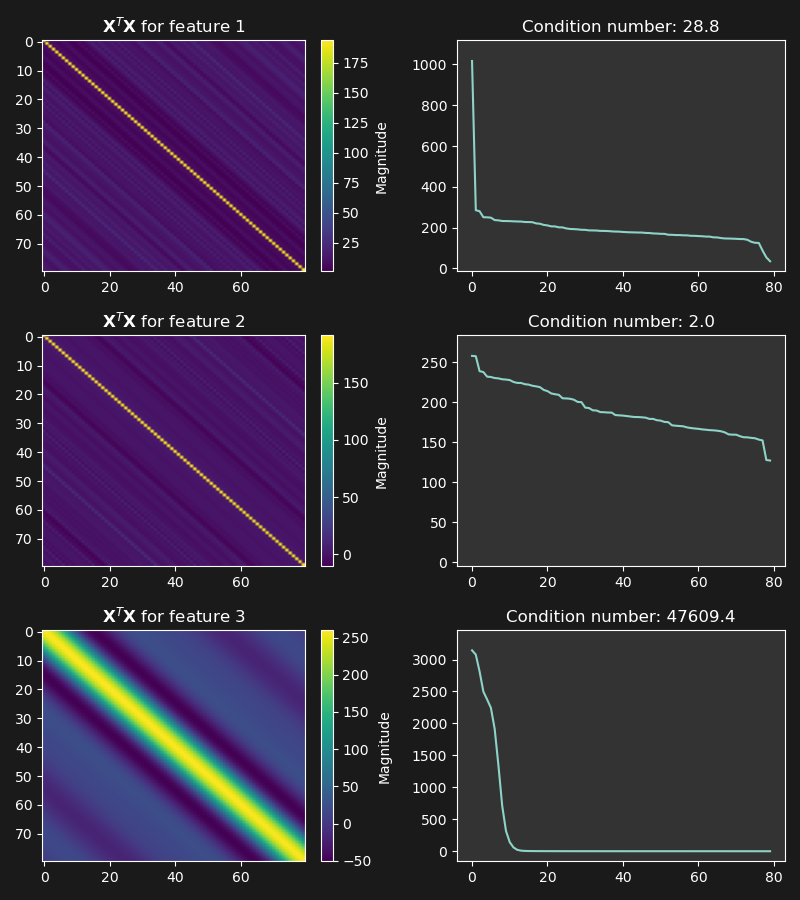

In [10]:
nlags = len(lags)
nfeatures = x.shape[1]

fc = 5.  # Hz
# Design the Butterworth lowpass filter
b, a = butter(4, fc, fs=100)
smoothed_signal = filtfilt(b, a, rng.normal(size=impulses.shape))
x[:, 2] = smoothed_signal
X = lag_matrix(x, lags)

plt.close('XtX')
f, ax = plt.subplots(nfeatures, 2, figsize=(8, 3*nfeatures), num='XtX')
for k in range(nfeatures):
    im = ax[k, 0].imshow(X[:, k*nlags:(k+1)*nlags].T @ X[:, k*nlags:(k+1)*nlags], aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Magnitude', ax=ax[k, 0])
    ax[k, 0].set_title(r'$\mathbf{X}^T\mathbf{X}$ for feature '+str(k+1))
    evals = np.linalg.eigvalsh(X[:, k*nlags:(k+1)*nlags].T @ X[:, k*nlags:(k+1)*nlags])[::-1]
    ax[k, 1].plot(evals)
    ax[k, 1].set_title(f'Condition number: {evals[0]/evals[-1]:.1f}')
    # ax[k, 1].set_yscale('log')
    ax[k, 1].set_ylim(min(ax[k, 1].get_ylim()[0], -5), evals.max()*1.1)
plt.tight_layout()

## Putting it all together: TRF Explorer

Let's wrap all these plots in an interactive figure so we can directly assess the consequence of change made to signals characteristics.

In [90]:
# Create a nice looking intecative plot using HTML and ipywidgets
%matplotlib widget
plt.ioff()  # Turn off interactive mode to prevent double plotting
display(
    HTML("""
<style>
.my-label-style label {
    color: white !important;
}
</style>
"""
))

# Initial setup of the figure and axes
plt.close('TRF Explorer')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), num='TRF Explorer')
gs = axes[0, 0].get_gridspec()
for ax in axes[0, :]:
    ax.remove()
ax_sig = fig.add_subplot(gs[0, 0:2])
ax_trf = fig.add_subplot(gs[0, 2:])
for ax in axes[1, :2]:
    ax.remove()
ax_fft = fig.add_subplot(gs[1, 0:2])
ax_xtx = axes[1, 2:]
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.layout.min_width = '800px'
fig.canvas.layout.min_height = '600px'

# Initialise plots and data

# Signals
pulses = simulate_regular_events(interval=0.3, jitter=0.025)
valued = pulses * rng.normal(size=pulses.shape)
smooth = lowpass_filter(valued, cutoff=8., fs=fs)
tker, kernel = create_kernel(bipolar=True)
lags = lag_span(tmin=-0.2, tmax=0.6, srate=fs) + 1
resp = convolve_with_kernel(pulses, kernel, tmin=-0.2, tmax=0.6, fs=fs)
snr = 3
sigma = np.std(resp) / snr
resp += rng.normal(0, sigma, size=resp.shape)
time = np.arange(0, 30., 1/fs)
# TRF
x = np.c_[pulses]
X = lag_matrix(x, lags)
XtX = X.T@X
alpha = 0.
beta = np.linalg.inv(XtX + alpha*np.eye(len(lags))) @ X.T @ resp

# Plot signals
resp_line, = ax_sig.plot(time, resp * 5., label='Response signal')
stim_line, = ax_sig.plot(time, pulses, color='crimson', label='Stimulus')
ax_sig.set_xlim(0, 10)
ax_sig.set_xlabel('Time (s)')
ax_sig.set_title('Signals')
ax_sig.legend()
# Plot TRFs
line_trf, = ax_trf.plot(tker*1e3, beta, label='TRF')
line_ker, = ax_trf.plot(tker*1e3, kernel, label='Ground truth', ls='--')
ax_trf.legend()
ax_trf.axvline(0., color=plt.rcParams['axes.edgecolor'], lw=1.)
ax_trf.set_xlabel('Time (ms)')
# Spectra
plot_fft(resp, fs=fs, ax=ax_fft)
plot_fft(beta, fs=fs, ax=ax_fft)
# XtX
im_xtx = ax_xtx[0].imshow(XtX)
evals = np.linalg.eigvalsh(XtX)[::-1]
eig_spectrum, = ax_xtx[1].plot(evals)
ax_xtx[1].set_title(f"Condition number: {evals[0]/evals[-1]:.1f}")

# Make widget boxes for layout
header = HTML(
    value="<h2>TRF Explorer</h2>"
          "This interactive figure allows you to explore how different parameters affect the estimated TRFs and the resulting EEG signal."
)
text_instructions = HTML(
    value="<b>Instructions:</b> Use the sliders and dropdowns to adjust parameters. "
          "The plots will update automatically to reflect your changes."
)
header.style.text_color = 'white'
text_instructions.style.text_color = 'white'

# Create widget controls
slider_impulse_interval = FloatSlider(value=0.3, min=0.01, max=1.0, step=0.01, description='Spike Interval (s):', continuous_update=True)
stim_type = Dropdown(options=['Event onsets', 'Valued pulses', 'Smooth signal'], value='Event onsets', description='Stimulus type:')
slider_snr = FloatSlider(value=3, min=-2.0, max=5.0, step=0.5, description='SNR (log-scale):', continuous_update=True)
slider_cutoff = FloatSlider(value=8., min=2.0, max=25.0, step=0.3, description='Cutoff (Hz):', continuous_update=True)
slider_lambda = FloatSlider(value=-1., min=-6.0, max=4.0, step=0.5, description='Regularisation (log-scale):', continuous_update=True)
checkbox_regularise = Checkbox(True, description="Apply regularisation: ")
button_reset = Button(description='Reset Parameters')

# Function to reset parameters to default values
def reset_parameters(b):
    slider_impulse_interval.value = 0.3
    stim_type.value = 'Event onsets'
    slider_snr.value = 3
    slider_cutoff.value = 8.
    slider_lambda.value = -1.
    checkbox_regularise.value = True    
button_reset.on_click(reset_parameters)

# Function to update plots based on widget values
def update_plots(pulse_interval, stim_type, snr, fc, alpha):
    # # Clear previous plots
    # for ax in axes.flatten():
    #     ax.clear()

    pulses = simulate_regular_events(interval=pulse_interval, jitter=0.025)
    valued = pulses * rng.normal(size=pulses.shape)
    smooth = lowpass_filter(valued, cutoff=fc, fs=fs)
    if stim_type == 'Event onsets':
        stim = pulses
    elif stim_type == 'Valued pulses':
        stim = valued
    else:
        stim = smooth
    resp = convolve_with_kernel(stim, kernel, tmin=-0.2, tmax=0.6, fs=fs)
    sigma = np.std(resp) / 10**snr
    resp += rng.normal(0, sigma, size=resp.shape)
    x = np.c_[stim]
    X = lag_matrix(x, lags)
    XtX = X.T@X
    evals = np.linalg.eigvalsh(XtX)[::-1]

    beta = np.linalg.inv(XtX + alpha*np.eye(len(lags))) @ X.T @ resp

    # Update line plots
    stim_line.set_ydata(stim)
    resp_line.set_ydata(resp)
    line_trf.set_ydata(beta)
    im_xtx.set_data(XtX)
    im_xtx.set_clim(np.min(XtX), np.max(XtX))
    eig_spectrum.set_ydata(np.linalg.eigvalsh(XtX)[::-1])
    ax_xtx[1].axes.relim()
    ax_xtx[1].autoscale_view(scaley=True)
    ax_xtx[1].set_title(f"Condition number: {evals[0]/evals[-1]:.1f}")
    ax_fft.clear()
    plot_fft(stim, fs=fs, ax=ax_fft)
    plot_fft(beta, fs=fs, ax=ax_fft)

    fig.canvas.draw_idle()

# assign update function
for w in [slider_impulse_interval, stim_type, slider_snr, slider_cutoff, slider_lambda, checkbox_regularise]:
    w.observe(lambda change: update_plots(slider_impulse_interval.value,
                                                                stim_type.value,
                                                                slider_snr.value,
                                                                slider_cutoff.value,
                                                                10**slider_lambda.value if checkbox_regularise.value else 0),
                                    names='value')

# Layout
text = VBox([header, text_instructions])
widgets = HBox([
     VBox([stim_type, slider_impulse_interval, slider_cutoff]),
     VBox([checkbox_regularise, slider_lambda, slider_snr])
])
VBox([text, widgets, button_reset, fig.canvas])

HTML(value='\n<style>\n.my-label-style label {\n    color: white !important;\n}\n</style>\n')

## Extra Tips

Some extra tips! As:
- how to compute pretty much _instantly_ the TRFs for as many regularisation parameters as your computer _memory_ allows
- or on organising the lag matrix for **banded ridge** regression, that is: different $\lambda$ for different features
- and finally, we will also see how to _weight_ samples with whatever external signal to compute a new set of coefficients directly from the closed-form equation solution.

### Conjugate Gradient

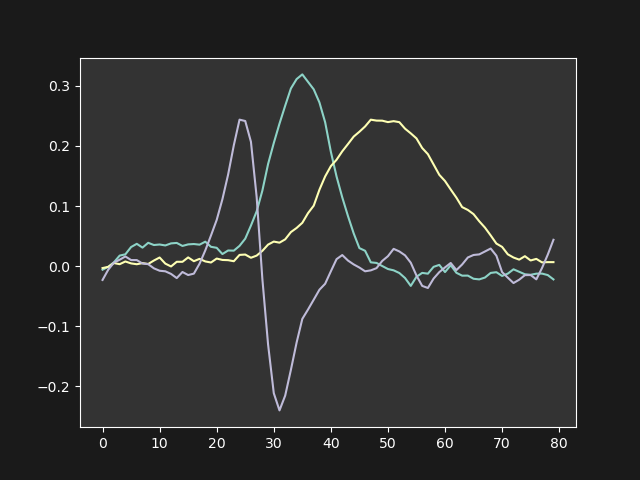

In [ ]:
plt.close('cg')
plt.figure('cg')
plt.plot(conjugate_gradient_solver(X, resp, ridge=3.0).reshape((80, 3), order='F'))